Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

### Agent Testing - Single Job Set

In this notebook we test the performance of the agent trained with a single job set.

We can then compare its performance to the random and shortest-job-first agents in the exploration notebook. Notice that in this case we are using the same job set for all agents.

Then we show the performance of the agent for an unseen job set and notice that it performs poorly, almost like a random agent.

This lab was tested with Ray version 0.8.5. Please make sure you have this version installed in your Compute Instance.

In [1]:
!pip install ray[rllib]==0.8.5

Import the necessary packages.

In [2]:
import sys, os  
sys.path.insert(0, os.path.join(os.getcwd(), '../agent_training/training_scripts/environment'))
os.environ.setdefault('PYTHONPATH', os.path.join(os.getcwd(), '../agent_training/training_scripts/environment'))

import ray
import ray.rllib.agents.pg as pg
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.annotations import override
from ray.tune.registry import register_env

import gym
from gym import spaces
from environment import Parameters, Env

import torch
import torch.nn as nn

import numpy as np

Here we define the RL environment class according to the Gym specification in the same way that was done in the agent training script. The difference is that here we add two new methods, *observe* and *plot_state_img*, allowing us to visualize the states of the environment as the agent acts.

Details about how to work with custom environment in RLLib can be found [here](https://docs.ray.io/en/master/rllib-env.html#configuring-environments).

We also introduce a new parameter to the environment constructor, *unseen*, which is a flag telling the environment to use unseen job sets, meaning job sets different than the ones used for training.

In [3]:
class CustomEnv(gym.Env):
    def __init__(self, env_config):
        simu_len = env_config['simu_len']
        num_ex = env_config['num_ex']
        unseen = env_config['unseen']
        
        pa = Parameters()
        pa.simu_len = simu_len
        pa.num_ex = num_ex
        pa.unseen = unseen
        pa.compute_dependent_parameters()
        
        self.env = Env(pa, render=False, repre='image')
        self.action_space = spaces.Discrete(n=pa.num_nw + 1)
        self.observation_space = spaces.Box(low=0, high=1, shape=self.env.observe().shape, dtype=np.float)
    
    def reset(self):
        self.env.reset()
        obs = self.env.observe()
        return obs
    
    def step(self, action):
        next_obs, reward, done, info = self.env.step(action)
        info = {}
        return next_obs, reward, done, info
    
    def observe(self):
        return self.env.observe()
    
    def plot_state_img(self):
        return self.env.plot_state_img()

Define the RL environment constructor and register it for use in RLLib.

In [4]:
def env_creator(env_config):
    return CustomEnv(env_config)

register_env('CustomEnv', env_creator)

Here we define the custom model for the agent policy. RLLib supports both TensorFlow and PyTorch and here we are using the PyTorch interfaces.

The policy model is a simple 2-layer feedforward neural network that maps the environment observation array into one of possible 6 actions. It also defines a value function network as a branch of the policy network, to output a single scalar value representing the expected sum of rewards. This value can be used as the baseline for the policy gradient algorithm.

More details about how to work with custom policy models with PyTorch in RLLib can be found [here](https://docs.ray.io/en/master/rllib-models.html#pytorch-models).

In [5]:
class CustomModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        
        self.hidden_layers = nn.Sequential(nn.Linear(20*124, 32), nn.ReLU(),
                                           nn.Linear(32, 16), nn.ReLU())
        
        self.logits = nn.Sequential(nn.Linear(16, 6))
        
        self.value_branch = nn.Sequential(nn.Linear(16, 1))

    @override(TorchModelV2)
    def forward(self, input_dict, state, seq_lens):
        obs = input_dict['obs'].float()
        obs = obs.view(obs.shape[0], 1, obs.shape[1], obs.shape[2])
        obs = obs.view(obs.shape[0], obs.shape[1] * obs.shape[2] * obs.shape[3])
        self.features = self.hidden_layers(obs)
        actions = self.logits(self.features)
        
        return actions, state
    
    @override(TorchModelV2)
    def value_function(self):
        return self.value_branch(self.features).squeeze(1)

Now we register the custom policy model for use in RLLib.

In [6]:
ModelCatalog.register_custom_model('CustomModel', CustomModel)

Here we create a copy of the default Policy Gradient configuration in RLLib and set the relevant parameters for testing a trained agent. In this case we only need the parameters related to the custom model and to our environment.

In [7]:
config = pg.DEFAULT_CONFIG
my_config = config.copy()

my_params = {
    'use_pytorch' : True,
    'model': {'custom_model': 'CustomModel'},
    'env': 'CustomEnv',
    'env_config': {'simu_len': 50, 'num_ex': 1, 'unseen': False}
}

for key, value in my_params.items():
    my_config[key] = value

Initialize the Ray backend. Here we run Ray locally.

In [8]:
ray.init()

2020-11-10 19:10:37,416	INFO resource_spec.py:212 -- Starting Ray with 27.98 GiB memory available for workers and up to 14.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-11-10 19:10:37,530	WARNING services.py:928 -- Redis failed to start, retrying now.
2020-11-10 19:10:38,081	INFO services.py:1170 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.0.0.5',
 'raylet_ip_address': '10.0.0.5',
 'redis_address': '10.0.0.5:21252',
 'object_store_address': '/tmp/ray/session_2020-11-10_19-10-37_414483_36668/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-10_19-10-37_414483_36668/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-11-10_19-10-37_414483_36668'}

Instantiate the policy gradient trainer object from RLLib.

In [9]:
trainer = pg.PGTrainer(config=my_config)

2020-11-10 19:10:38,192	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-11-10 19:10:38,243	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-11-10 19:10:39,118	WARNING trainer_template.py:124 -- The experimental distributed execution API is enabled for this algorithm. Disable this by setting 'use_exec_api': False.
2020-11-10 19:10:39,119	INFO trainable.py:217 -- Getting current IP.
2020-11-10 19:10:39,120	WARNING util.py:37 -- Install gputil for GPU system monitoring.


We can verify the policy model architecture by getting a reference to the policy object from the trainer and a reference to the model object from the policy.

In [10]:
policy = trainer.get_policy()
model = policy.model
print(model.parameters)

<bound method Module.parameters of CustomModel(
  (hidden_layers): Sequential(
    (0): Linear(in_features=2480, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
  )
  (logits): Sequential(
    (0): Linear(in_features=16, out_features=6, bias=True)
  )
  (value_branch): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)>


Here we load the model checkpoint, corresponding to the single job set training, into the trainer.

In [11]:
checkpoint_path = '../model_checkpoints/single_jobset/checkpoint-300'

trainer.restore(checkpoint_path=checkpoint_path)

2020-11-10 19:10:39,379	INFO trainable.py:217 -- Getting current IP.
2020-11-10 19:10:39,380	INFO trainable.py:423 -- Restored on 10.0.0.5 from checkpoint: ../model_checkpoints/single_jobset/checkpoint-300
2020-11-10 19:10:39,380	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 2983.7504589557648, '_episodes_total': 422525}


We then perform a rollout of the trained policy into the RL environment, using the same single job set used for training.

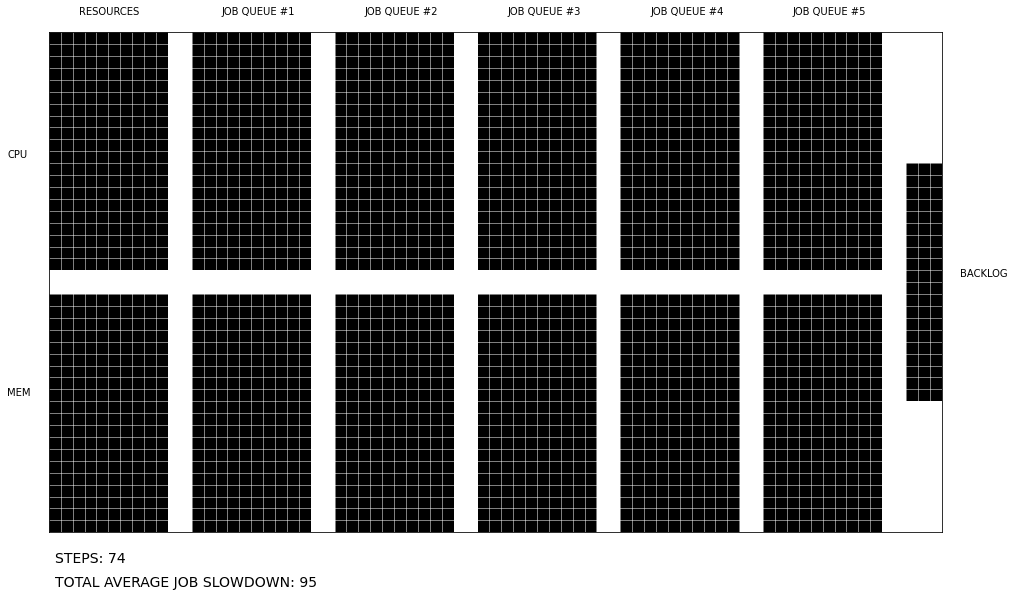

In [12]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import time
from random import randint

env = CustomEnv(env_config = my_params['env_config'])

img = env.plot_state_img()

plt.figure(figsize = (16,16))
plt.grid(color='w', linestyle='-', linewidth=0.5)
plt.text(2, -2, "RESOURCES")
plt.text(-4, 10, "CPU")
plt.text(-4, 30, "MEM")
plt.text(14, -2, "JOB QUEUE #1")
plt.text(26, -2, "JOB QUEUE #2")
plt.text(38, -2, "JOB QUEUE #3")
plt.text(50, -2, "JOB QUEUE #4")
plt.text(62, -2, "JOB QUEUE #5")
plt.text(76, 20, "BACKLOG")
plt.imshow(img, vmax=1, cmap='CMRmap')
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 100, 1))
ax.set_xticklabels([])
ax.set_yticks(np.arange(-.5, 100, 1))
ax.set_yticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

image = plt.imshow(img, vmax=1, cmap='CMRmap')
display.display(plt.gcf())

actions = []
rewards = []
done = False
s = 0
txt1 = plt.text(0, 45, '')
txt2 = plt.text(0, 47, '')

obs = env.observe()
while not done:
    a = trainer.compute_action(obs)
    actions.append(a)
    obs, reward, done, info = env.step(a)
    rewards.append(reward)
    s += 1
    txt1.remove()
    txt2.remove()
    txt1 = plt.text(0, 44, 'STEPS: ' + str(s), fontsize=14)
    txt2 = plt.text(0, 46, 'TOTAL AVERAGE JOB SLOWDOWN: ' + str(round(-sum(rewards))), fontsize=14)
    
    img = env.plot_state_img()
    image.set_data(img)
    display.display(plt.gcf())
    display.clear_output(wait=True)

And finally we perform another rollout of the trained policy, but now using an unseen job set, meaning a job set different from the one used for training. We notice here that the agent is not able to generalize well and its performance is similar to the performance of a random policy.

This will be mitigated by training the agent with multiple distinct job sets.

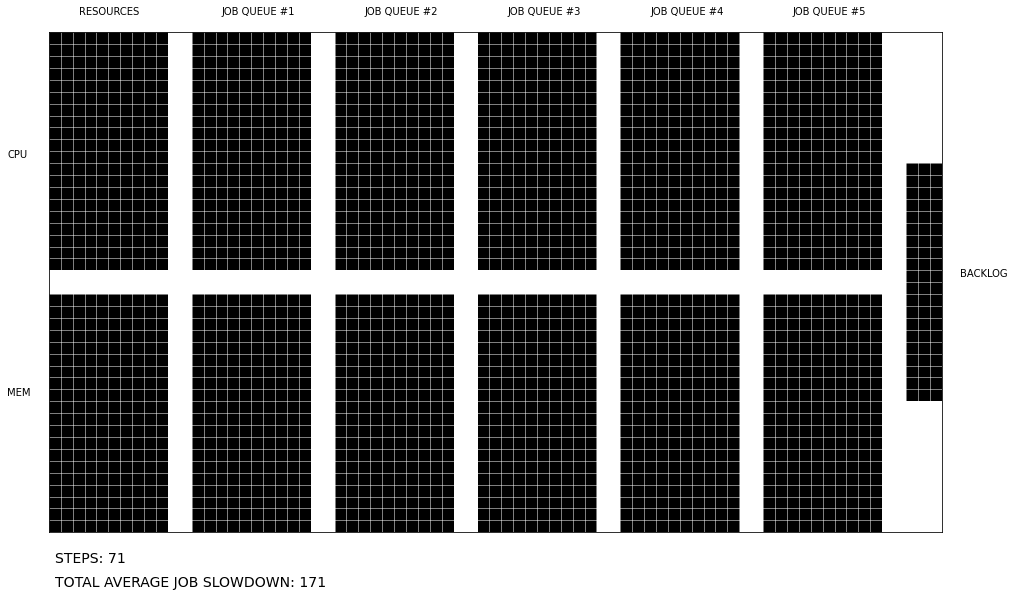

In [13]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import time
from random import randint

env_config = my_params['env_config']
env_config['unseen'] = True

env = CustomEnv(env_config=env_config)

img = env.plot_state_img()

plt.figure(figsize = (16,16))
plt.grid(color='w', linestyle='-', linewidth=0.5)
plt.text(2, -2, "RESOURCES")
plt.text(-4, 10, "CPU")
plt.text(-4, 30, "MEM")
plt.text(14, -2, "JOB QUEUE #1")
plt.text(26, -2, "JOB QUEUE #2")
plt.text(38, -2, "JOB QUEUE #3")
plt.text(50, -2, "JOB QUEUE #4")
plt.text(62, -2, "JOB QUEUE #5")
plt.text(76, 20, "BACKLOG")
plt.imshow(img, vmax=1, cmap='CMRmap')
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 100, 1))
ax.set_xticklabels([])
ax.set_yticks(np.arange(-.5, 100, 1))
ax.set_yticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

image = plt.imshow(img, vmax=1, cmap='CMRmap')
display.display(plt.gcf())

actions = []
rewards = []
done = False
s = 0
txt1 = plt.text(0, 45, '')
txt2 = plt.text(0, 47, '')

obs = env.observe()
while not done:
    a = trainer.compute_action(obs)
    actions.append(a)
    obs, reward, done, info = env.step(a)
    rewards.append(reward)
    s += 1
    txt1.remove()
    txt2.remove()
    txt1 = plt.text(0, 44, 'STEPS: ' + str(s), fontsize=14)
    txt2 = plt.text(0, 46, 'TOTAL AVERAGE JOB SLOWDOWN: ' + str(round(-sum(rewards))), fontsize=14)
    
    img = env.plot_state_img()
    image.set_data(img)
    display.display(plt.gcf())
    display.clear_output(wait=True)

Shutdown the Ray backend.

In [14]:
ray.shutdown()